In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import random
random.seed(56)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from datetime import datetime as dt
from sklearn.model_selection import StratifiedKFold

import lightgbm
import optuna
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

## Dataset

In [42]:
# 학습 데이터
train = pd.read_csv('./train.csv')
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
* Y_Quality : 제품 품질 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [43]:
# 검증 데이터
test = pd.read_csv('./test.csv')
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [44]:
# 제출 양식
subm = pd.read_csv('./sample_submission.csv')
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

### Y Class & Y Quality

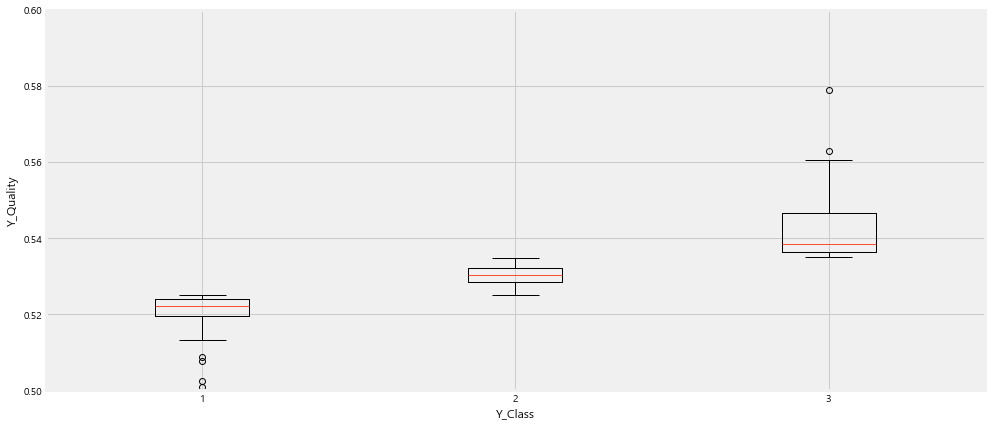

In [45]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots()

ax.boxplot([train[train['Y_Class']==0].Y_Quality, train[train['Y_Class']==1].Y_Quality, train[train['Y_Class']==2].Y_Quality])
ax.set_ylim(0.5, 0.6)
ax.set_xlabel('Y_Class')
ax.set_ylabel('Y_Quality')
plt.show()

In [46]:
# Class는 Quality를 3등분한 결과
for i in range(3):
    tmp = train[train['Y_Class']==i].Y_Quality
    print(f'Class : {i}, Quality range : {min(tmp)} ~ {max(tmp)}')

Class : 0, Quality range : 0.500855556 ~ 0.525066667
Class : 1, Quality range : 0.525085714 ~ 0.534842857
Class : 2, Quality range : 0.534950794 ~ 0.57884127


In [47]:
train.Y_Class.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

### Product Code value counts

In [48]:
# Product Code는 3가지로 이루어져 있다.
for code in train['PRODUCT_CODE'].unique():
    print(code, len(train[train['PRODUCT_CODE']==code]))

A_31 249
T_31 343
O_31 6


### TimeStamp

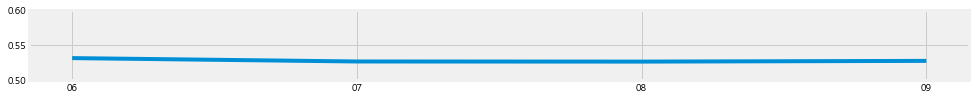

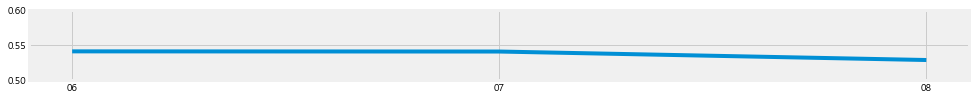

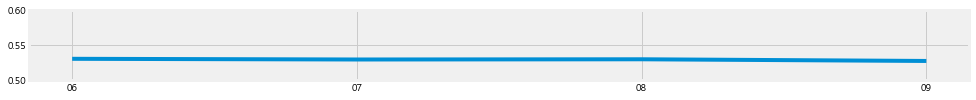

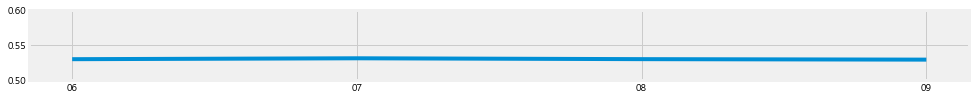

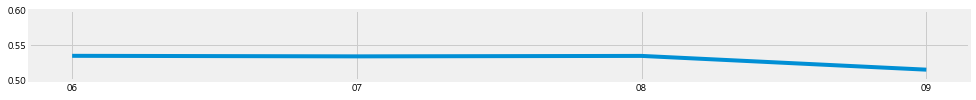

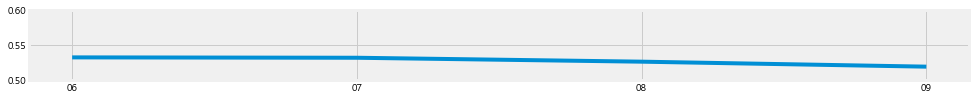

In [49]:
# 시간대별 Line의 Quality 비교
rcParams['figure.figsize'] = 15, 9

for i, line in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==line]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.ylim(0.5, 0.6)
    plt.show()

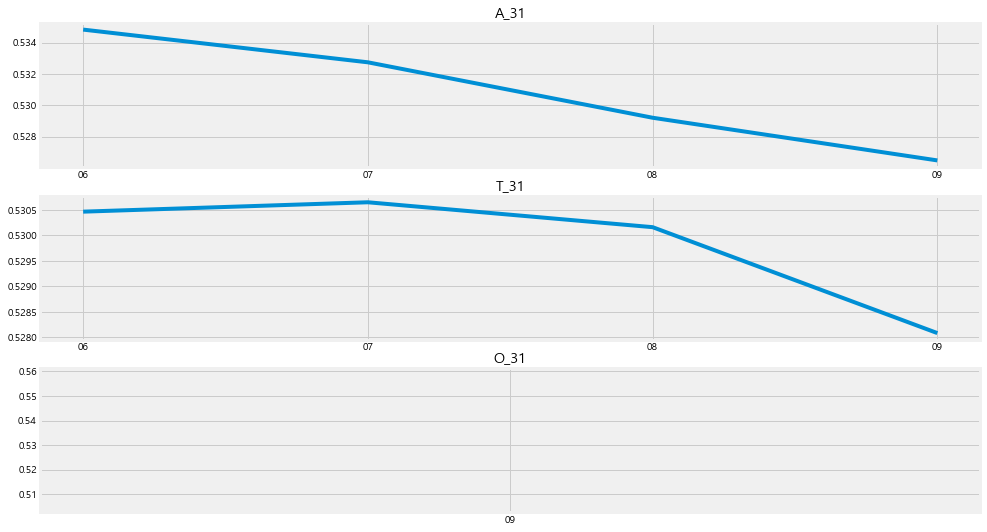

In [50]:
# 시간대별 Product Code의 Quality 비교
rcParams['figure.figsize'] = 15, 9

for i, code in enumerate(train.PRODUCT_CODE.unique()):
    plt.subplot(len(train.PRODUCT_CODE.unique()), 1, i+1)
    tmp = train[train['PRODUCT_CODE']==code]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(code)
plt.show()

In [51]:
train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP']).dt.strftime('%m')
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,06,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,06,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,06,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,06,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,06,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


### X_1 ~ X_2875

In [52]:
len(train.columns)

2881

In [53]:
for x in train.columns[6:]:
    if train[train[x].isnull()]['PRODUCT_CODE'].nunique() + train[train[x].notnull()]['PRODUCT_CODE'].nunique() != 3:
        train.drop(columns=[x], inplace=True)

len(train.columns)

560

In [54]:
train.fillna(0, inplace=True)
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,06,T050304,A_31,0.0,0.0,0.0,0.0,...,209.0,197.286667,189.0,383.0,368.296296,353.0,0.0,0.0,0.0,0.0
1,TRAIN_001,2,0.541819,06,T050307,A_31,0.0,0.0,0.0,0.0,...,198.0,193.296552,185.6,383.0,367.735849,353.0,0.0,0.0,0.0,0.0
2,TRAIN_002,1,0.531267,06,T050304,A_31,0.0,0.0,0.0,0.0,...,193.4,179.820690,165.5,383.0,367.320755,353.0,0.0,0.0,0.0,0.0
3,TRAIN_003,2,0.537325,06,T050307,A_31,0.0,0.0,0.0,0.0,...,190.3,181.920690,165.8,384.0,369.188679,353.0,0.0,0.0,0.0,0.0
4,TRAIN_004,1,0.531590,06,T050304,A_31,0.0,0.0,0.0,0.0,...,208.6,196.393333,182.6,383.0,367.351852,352.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,09,T100306,T_31,2.0,95.0,0.0,45.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
594,TRAIN_594,0,0.524022,09,T050304,A_31,0.0,0.0,0.0,0.0,...,198.3,180.810345,168.7,384.0,369.811321,353.0,0.0,0.0,0.0,0.0
595,TRAIN_595,0,0.521289,09,T050304,A_31,0.0,0.0,0.0,0.0,...,186.5,176.486207,156.6,383.0,367.018868,352.0,0.0,0.0,0.0,0.0
596,TRAIN_596,1,0.531375,09,T100304,O_31,40.0,94.0,0.0,45.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### astype

In [55]:
train.dtypes

PRODUCT_ID     object
Y_Class         int64
Y_Quality     float64
TIMESTAMP      object
LINE           object
               ...   
X_2865        float64
X_2872        float64
X_2873        float64
X_2874        float64
X_2875        float64
Length: 560, dtype: object

In [56]:
train['TIMESTAMP'] = train['TIMESTAMP'].astype('int')
train['TIMESTAMP'].dtypes

dtype('int32')

### data split & astype

In [57]:
train.drop(columns=['PRODUCT_ID'], inplace=True)
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')
train.head()

,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2872,X_2873,X_2874,X_2875
0,1,0.533433,6,T050304,A_31,0.0,0.0,0.0,0.0,0.0,...,209.0,197.286667,189.0,383.0,368.296296,353.0,0.0,0.0,0.0,0.0
1,2,0.541819,6,T050307,A_31,0.0,0.0,0.0,0.0,0.0,...,198.0,193.296552,185.6,383.0,367.735849,353.0,0.0,0.0,0.0,0.0
2,1,0.531267,6,T050304,A_31,0.0,0.0,0.0,0.0,0.0,...,193.4,179.820690,165.5,383.0,367.320755,353.0,0.0,0.0,0.0,0.0
3,2,0.537325,6,T050307,A_31,0.0,0.0,0.0,0.0,0.0,...,190.3,181.920690,165.8,384.0,369.188679,353.0,0.0,0.0,0.0,0.0
4,1,0.531590,6,T050304,A_31,0.0,0.0,0.0,0.0,0.0,...,208.6,196.393333,182.6,383.0,367.351852,352.0,0.0,0.0,0.0,0.0


In [65]:
test = test[train.columns[2:]]
test.fillna(0, inplace=True)
test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP']).dt.strftime('%m').astype('int')
test['LINE'] = test['LINE'].astype('category')
test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')

test.head()

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2860,X_2861,X_2862,X_2863,X_2864,X_2865,X_2872,X_2873,X_2874,X_2875
0,9,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,9,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,9,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,9,T010305,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,198.0,191.450000,183.8,467.0,444.192308,423.0,0.0,0.0,0.0,0.0
4,9,T010306,A_31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,210.2,193.082143,179.7,465.0,443.211539,423.0,0.0,0.0,0.0,0.0


### Standard Scaler

In [122]:
from sklearn.preprocessing import StandardScaler
stscaler = StandardScaler().fit(x_train[x_train.columns[3:]])
x_train[x_train.columns[3:]] = stscaler.transform(x_train[x_train.columns[3:]])
test[test.columns[3:]] = stscaler.transform(test[test.columns[3:]])
test.head()

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,2,T100306,T_31,0.127626,0.818890,0.0,0.844670,0.766018,0.0,0.927147,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
1,2,T100304,T_31,0.127626,0.797612,0.0,0.844670,0.960697,0.0,0.680110,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
2,8,T100304,T_31,0.127626,0.840168,0.0,0.844670,0.960697,0.0,0.680110,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
3,10,T010305,A_31,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0
4,11,T010306,A_31,-0.302348,-1.181260,0.0,-1.183895,-1.180768,0.0,-1.172670,...,-0.443122,-0.442094,-0.442664,-0.440386,-0.446886,-0.445418,0.0,0.0,0.0,0.0


### PCA

,pc_ratio
pc1,6.440508e-01
pc2,3.559492e-01
pc3,1.620285e-13
pc4,2.563217e-15
pc5,1.279468e-15


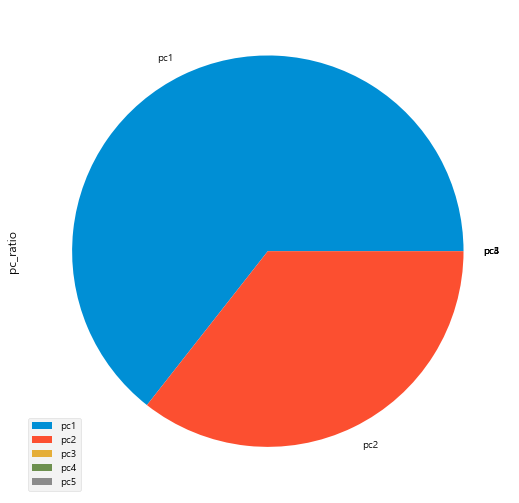

In [69]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train[x_train.columns[3:]])
ratio = pca.explained_variance_ratio_

df_v = pd.DataFrame(ratio[:5], index=[f'pc{i+1}' for i in range(5)], columns=['pc_ratio'])
df_v.plot.pie(y='pc_ratio')
df_v

In [70]:
n = 3
pca = PCA(n_components=n)
pc = pca.fit_transform(x_train[x_train.columns[3:]])
xtrain_pca = pd.DataFrame(pc, columns = [f'pc{i+1}' for i in range(n)])
xtrain_pca.head()

,pc1,pc2
0,1.753206e+13,1.782243e+12
1,-5.988863e+12,1.799477e+13
2,1.753206e+13,1.782243e+12
3,-5.988863e+12,1.799477e+13
4,1.753206e+13,1.782243e+12


In [71]:
pc = pca.transform(test[test.columns[3:]])
test_pca = pd.DataFrame(pc, columns = [f'pc{i+1}' for i in range(n)])
test_pca.head()

,pc1,pc2
0,-2.334663e+12,-1.871957e+12
1,-2.334663e+12,-1.871957e+12
2,-2.334663e+12,-1.871957e+12
3,-2.334663e+12,-1.871957e+12
4,-2.334663e+12,-1.871957e+12


In [72]:
x_train = pd.concat([x_train[x_train.columns[:3]], xtrain_pca], axis=1)
test = pd.concat([test[test.columns[:3]], test_pca], axis=1)
x_train.head()

,TIMESTAMP,LINE,PRODUCT_CODE,pc1,pc2
0,5,T050304,A_31,1.753206e+13,1.782243e+12
1,5,T050307,A_31,-5.988863e+12,1.799477e+13
2,5,T050304,A_31,1.753206e+13,1.782243e+12
3,5,T050307,A_31,-5.988863e+12,1.799477e+13
4,5,T050304,A_31,1.753206e+13,1.782243e+12


### Optuna

In [36]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

def lgbm_objective(trial):

    params = {
            "objective": "regression",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 256),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    reg = lightgbm.LGBMRegressor(**params)
    
    f1_list = []
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_class)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_quality.loc[train_index], y_quality.loc[val_index]
        y_cls_val = y_class.loc[val_index]
        reg.fit(x_trn, y_trn)
        pred_quality = reg.predict(x_val)
        
        pred_class = []
        for q in pred_quality:
            if q >= 0.5349: pred_class.append(2)
            elif q <= 0.525075: pred_class.append(0)
            else: pred_class.append(1)

        f1_list.append(f1_score(pred_class, y_cls_val, average='micro'))    
    
    return np.mean(f1_list)

In [37]:
# split
x_train = train.drop(columns=['Y_Class', 'Y_Quality'])
y_class = train['Y_Class']
y_quality = train['Y_Quality']

# optuna
study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective, n_trials=200, show_progress_bar=True)

[I 2023-02-05 01:02:43,954] A new study created in memory with name: no-name-a3b33505-89f1-4277-8cac-3fa610259faf


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-02-05 01:02:44,823] Trial 0 finished with value: 0.6806022408963587 and parameters: {'max_depth': 252, 'num_leaves': 208, 'learning_rate': 0.222497160167814, 'n_estimators': 1400, 'colsample_bytree': 0.6859445599605205, 'colsample_bynode': 0.5324501478393288, 'reg_lambda': 0.4632573771707999, 'reg_alpha': 0.5371791373526377, 'min_child_weight': 6, 'min_child_samples': 82}. Best is trial 0 with value: 0.6806022408963587.
[I 2023-02-05 01:02:46,382] Trial 1 finished with value: 0.6706022408963586 and parameters: {'max_depth': 33, 'num_leaves': 730, 'learning_rate': 0.5530813151541802, 'n_estimators': 2000, 'colsample_bytree': 0.670571453277008, 'colsample_bynode': 0.9225800569380459, 'reg_lambda': 0.6657236659183732, 'reg_alpha': 0.022915281506968414, 'min_child_weight': 10, 'min_child_samples': 52}. Best is trial 0 with value: 0.6806022408963587.
[I 2023-02-05 01:02:46,717] Trial 2 finished with value: 0.6956302521008403 and parameters: {'max_depth': 172, 'num_leaves': 36, 'lear

[I 2023-02-05 01:03:02,511] Trial 19 finished with value: 0.7107002801120449 and parameters: {'max_depth': 90, 'num_leaves': 2, 'learning_rate': 0.40059531022895295, 'n_estimators': 1400, 'colsample_bytree': 0.785298076320494, 'colsample_bynode': 0.9839679627767001, 'reg_lambda': 0.8509753440561807, 'reg_alpha': 0.05618632787422493, 'min_child_weight': 13, 'min_child_samples': 20}. Best is trial 11 with value: 0.7257563025210084.
[I 2023-02-05 01:03:05,174] Trial 20 finished with value: 0.7341316526610644 and parameters: {'max_depth': 145, 'num_leaves': 11, 'learning_rate': 0.02672085265789486, 'n_estimators': 2100, 'colsample_bytree': 0.8342317979008568, 'colsample_bynode': 0.8794388974520143, 'reg_lambda': 0.5318960783002122, 'reg_alpha': 0.021300550796727522, 'min_child_weight': 10, 'min_child_samples': 18}. Best is trial 20 with value: 0.7341316526610644.
[I 2023-02-05 01:03:09,572] Trial 21 finished with value: 0.7123949579831933 and parameters: {'max_depth': 150, 'num_leaves': 13

[I 2023-02-05 01:03:23,239] Trial 38 finished with value: 0.7173949579831933 and parameters: {'max_depth': 128, 'num_leaves': 31, 'learning_rate': 0.48587628537588956, 'n_estimators': 300, 'colsample_bytree': 0.6650807762960257, 'colsample_bynode': 0.8621232935361076, 'reg_lambda': 0.17019432493830092, 'reg_alpha': 0.0500560225333908, 'min_child_weight': 9, 'min_child_samples': 11}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:03:24,491] Trial 39 finished with value: 0.6973949579831933 and parameters: {'max_depth': 143, 'num_leaves': 8, 'learning_rate': 0.2991670203628648, 'n_estimators': 1800, 'colsample_bytree': 0.7251964584909741, 'colsample_bynode': 0.8254157203834831, 'reg_lambda': 0.08279551351374287, 'reg_alpha': 0.015554923582005982, 'min_child_weight': 7, 'min_child_samples': 20}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:03:25,322] Trial 40 finished with value: 0.6905882352941177 and parameters: {'max_depth': 226, 'num_leaves': 48,

[I 2023-02-05 01:03:37,767] Trial 57 finished with value: 0.7157422969187676 and parameters: {'max_depth': 139, 'num_leaves': 15, 'learning_rate': 0.110708139808791, 'n_estimators': 100, 'colsample_bytree': 0.9234241241157866, 'colsample_bynode': 0.9645079932794683, 'reg_lambda': 0.4583150120604013, 'reg_alpha': 0.018001482952648192, 'min_child_weight': 9, 'min_child_samples': 38}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:03:38,638] Trial 58 finished with value: 0.7174089635854342 and parameters: {'max_depth': 219, 'num_leaves': 35, 'learning_rate': 0.06124407032370488, 'n_estimators': 300, 'colsample_bytree': 0.8774447098142208, 'colsample_bynode': 0.9922837673266862, 'reg_lambda': 0.5673695520093949, 'reg_alpha': 0.023374444122708612, 'min_child_weight': 14, 'min_child_samples': 31}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:03:41,452] Trial 59 finished with value: 0.6856442577030812 and parameters: {'max_depth': 81, 'num_leaves': 9, '

[I 2023-02-05 01:03:56,913] Trial 76 finished with value: 0.7275210084033613 and parameters: {'max_depth': 40, 'num_leaves': 882, 'learning_rate': 0.11483488296532997, 'n_estimators': 300, 'colsample_bytree': 0.7588682145020024, 'colsample_bynode': 0.9135379346253047, 'reg_lambda': 0.10044510708835043, 'reg_alpha': 0.018810966493537196, 'min_child_weight': 8, 'min_child_samples': 23}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:03:57,734] Trial 77 finished with value: 0.7139775910364147 and parameters: {'max_depth': 42, 'num_leaves': 886, 'learning_rate': 0.2303068545753961, 'n_estimators': 500, 'colsample_bytree': 0.7123317934115739, 'colsample_bynode': 0.8598551926468238, 'reg_lambda': 0.12140786554481399, 'reg_alpha': 0.01803259503447632, 'min_child_weight': 8, 'min_child_samples': 18}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:03:58,138] Trial 78 finished with value: 0.7207282913165267 and parameters: {'max_depth': 147, 'num_leaves': 58

[I 2023-02-05 01:04:10,041] Trial 95 finished with value: 0.7257002801120448 and parameters: {'max_depth': 219, 'num_leaves': 412, 'learning_rate': 0.2042221981325192, 'n_estimators': 400, 'colsample_bytree': 0.8303404530964046, 'colsample_bynode': 0.9776649462050396, 'reg_lambda': 0.5796345507697244, 'reg_alpha': 0.04338874406215234, 'min_child_weight': 11, 'min_child_samples': 20}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:04:10,546] Trial 96 finished with value: 0.7039355742296919 and parameters: {'max_depth': 241, 'num_leaves': 326, 'learning_rate': 0.34091436866383307, 'n_estimators': 600, 'colsample_bytree': 0.7196063752519078, 'colsample_bynode': 0.9533294449070601, 'reg_lambda': 0.7554930032849331, 'reg_alpha': 0.05996807706553, 'min_child_weight': 10, 'min_child_samples': 31}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:04:11,211] Trial 97 finished with value: 0.6973249299719889 and parameters: {'max_depth': 252, 'num_leaves': 659,

[I 2023-02-05 01:04:33,111] Trial 114 finished with value: 0.7206862745098039 and parameters: {'max_depth': 145, 'num_leaves': 86, 'learning_rate': 0.20802578918960055, 'n_estimators': 2300, 'colsample_bytree': 0.7708080862696568, 'colsample_bynode': 0.8773410850529934, 'reg_lambda': 0.12058625320038278, 'reg_alpha': 0.07159582863464496, 'min_child_weight': 10, 'min_child_samples': 19}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:04:34,445] Trial 115 finished with value: 0.7139915966386555 and parameters: {'max_depth': 164, 'num_leaves': 685, 'learning_rate': 0.13796279819909904, 'n_estimators': 1900, 'colsample_bytree': 0.7032081822888405, 'colsample_bynode': 0.9990419537693209, 'reg_lambda': 0.4624332200658529, 'reg_alpha': 0.04180686417996934, 'min_child_weight': 9, 'min_child_samples': 39}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:04:36,145] Trial 116 finished with value: 0.7173949579831934 and parameters: {'max_depth': 178, 'num_leave

[I 2023-02-05 01:04:50,412] Trial 133 finished with value: 0.7023949579831934 and parameters: {'max_depth': 15, 'num_leaves': 749, 'learning_rate': 0.1192004733614388, 'n_estimators': 300, 'colsample_bytree': 0.7553136840791326, 'colsample_bynode': 0.962754712204504, 'reg_lambda': 0.08534141036973823, 'reg_alpha': 0.0652864662494192, 'min_child_weight': 11, 'min_child_samples': 22}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:04:50,983] Trial 134 finished with value: 0.7157703081232494 and parameters: {'max_depth': 44, 'num_leaves': 852, 'learning_rate': 0.21947470687060885, 'n_estimators': 400, 'colsample_bytree': 0.8268050370011208, 'colsample_bynode': 0.9738395179103432, 'reg_lambda': 0.0731649266685334, 'reg_alpha': 0.05628073311027259, 'min_child_weight': 10, 'min_child_samples': 30}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:04:51,624] Trial 135 finished with value: 0.7123249299719887 and parameters: {'max_depth': 151, 'num_leaves': 5

[I 2023-02-05 01:05:03,097] Trial 152 finished with value: 0.7441456582633054 and parameters: {'max_depth': 86, 'num_leaves': 11, 'learning_rate': 0.044372476510464505, 'n_estimators': 400, 'colsample_bytree': 0.7291690909664905, 'colsample_bynode': 0.9687738793741583, 'reg_lambda': 0.027691669863368348, 'reg_alpha': 0.05145079580155384, 'min_child_weight': 9, 'min_child_samples': 16}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:05:03,773] Trial 153 finished with value: 0.7357843137254902 and parameters: {'max_depth': 91, 'num_leaves': 12, 'learning_rate': 0.04209869171073308, 'n_estimators': 400, 'colsample_bytree': 0.7318809078616583, 'colsample_bynode': 0.970190795323694, 'reg_lambda': 0.027776353761238787, 'reg_alpha': 0.043153779769772596, 'min_child_weight': 9, 'min_child_samples': 17}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:05:04,901] Trial 154 finished with value: 0.7223529411764706 and parameters: {'max_depth': 80, 'num_leaves':

[I 2023-02-05 01:05:18,943] Trial 171 finished with value: 0.7307703081232494 and parameters: {'max_depth': 59, 'num_leaves': 16, 'learning_rate': 0.044686162914349736, 'n_estimators': 400, 'colsample_bytree': 0.7180356996859859, 'colsample_bynode': 0.9620220973171192, 'reg_lambda': 0.04547598014746667, 'reg_alpha': 0.048925597484982784, 'min_child_weight': 8, 'min_child_samples': 17}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:05:19,454] Trial 172 finished with value: 0.7324789915966387 and parameters: {'max_depth': 64, 'num_leaves': 9, 'learning_rate': 0.07000514493890801, 'n_estimators': 300, 'colsample_bytree': 0.7027211686252547, 'colsample_bynode': 0.9893690069790395, 'reg_lambda': 0.02562907878218669, 'reg_alpha': 0.042038783984269884, 'min_child_weight': 9, 'min_child_samples': 20}. Best is trial 34 with value: 0.7441596638655461.
[I 2023-02-05 01:05:19,988] Trial 173 finished with value: 0.7208263305322129 and parameters: {'max_depth': 64, 'num_leaves': 

[I 2023-02-05 01:05:36,779] Trial 190 finished with value: 0.7442156862745098 and parameters: {'max_depth': 106, 'num_leaves': 8, 'learning_rate': 0.011636209704842512, 'n_estimators': 1500, 'colsample_bytree': 0.7164467435370601, 'colsample_bynode': 0.9500137443889628, 'reg_lambda': 0.0464357868041519, 'reg_alpha': 0.05511151376356798, 'min_child_weight': 8, 'min_child_samples': 10}. Best is trial 190 with value: 0.7442156862745098.
[I 2023-02-05 01:05:37,983] Trial 191 finished with value: 0.7207563025210085 and parameters: {'max_depth': 111, 'num_leaves': 15, 'learning_rate': 0.011948307276198611, 'n_estimators': 400, 'colsample_bytree': 0.7147011365959126, 'colsample_bynode': 0.9500888831902522, 'reg_lambda': 0.035149181742318736, 'reg_alpha': 0.05449671688222702, 'min_child_weight': 8, 'min_child_samples': 10}. Best is trial 190 with value: 0.7442156862745098.
[I 2023-02-05 01:05:38,349] Trial 192 finished with value: 0.6806022408963587 and parameters: {'max_depth': 105, 'num_leav

In [38]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")

trial = study.best_trial

print("  mae : {}".format(trial.value))
print("  Best hyperparameters: ")

for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  200
Best trial:
  mae : 0.7442156862745098
  Best hyperparameters: 
    max_depth: 106
    num_leaves: 8
    learning_rate: 0.011636209704842512
    n_estimators: 1500
    colsample_bytree: 0.7164467435370601
    colsample_bynode: 0.9500137443889628
    reg_lambda: 0.0464357868041519
    reg_alpha: 0.05511151376356798
    min_child_weight: 8
    min_child_samples: 10


In [39]:
study.best_params

{'max_depth': 106,
 'num_leaves': 8,
 'learning_rate': 0.011636209704842512,
 'n_estimators': 1500,
 'colsample_bytree': 0.7164467435370601,
 'colsample_bynode': 0.9500137443889628,
 'reg_lambda': 0.0464357868041519,
 'reg_alpha': 0.05511151376356798,
 'min_child_weight': 8,
 'min_child_samples': 10}

In [66]:
reg = lightgbm.LGBMRegressor(**study.best_params)
reg.fit(x_train, y_quality, verbose=0)

for i, quality in enumerate(reg.predict(test)):
    if quality >= 0.5349: subm['Y_Class'][i] = 2
    elif quality <= 0.525075: subm['Y_Class'][i] = 0
    else: subm['Y_Class'][i] = 1
        
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,1
1,TEST_001,1
2,TEST_002,1
3,TEST_003,1
4,TEST_004,1


In [67]:
subm.Y_Class.value_counts()

1    258
2     35
0     17
Name: Y_Class, dtype: int64

In [68]:
pred = []
for i, quality in enumerate(reg.predict(x_train)):
    if quality >= 0.5349: pred.append(2)
    elif quality <= 0.525075: pred.append(0)
    else: pred.append(1)
f1_score(pred, y_class, average='macro')

0.729307907697017

In [ ]:
###Y_Quality를 예측->proba로 이용해보자

In [456]:
#subm.to_csv('submission5.csv', index=False) # optuna_micro_lgbm_pca2_partlyx0

In [497]:
#subm.to_csv('submission6.csv', index=False) # optuna_macro_lgbm_pca3_allx0_stscaler

In [103]:
#subm.to_csv('submission7.csv', index=False) # optuna_quality_lgbm_allx0

In [148]:
#subm.to_csv('submission8.csv', index=False) # optuna_quality_lgbm_partlyx0

In [150]:
tmp = pd.read_csv('./submission3.csv')
tmp.Y_Class.value_counts()

1    266
0     38
2      6
Name: Y_Class, dtype: int64